# Check rotamer angles for vanilla eq 

## T42A

In [1]:
import mdtraj as md
import numpy as np
import pickle
import os
from tqdm import tqdm_notebook
from simtk.openmm import app
from simtk.openmm import unit
import matplotlib.pyplot as plt
from pymbar import timeseries

In [2]:
def new_positions(htf, hybrid_positions):
    n_atoms_new = htf._topology_proposal.n_atoms_new
    hybrid_indices = [htf._new_to_hybrid_map[idx] for idx in range(n_atoms_new)]
    return hybrid_positions[hybrid_indices, :]

def old_positions(htf, hybrid_positions):
    n_atoms_old = htf._topology_proposal.n_atoms_old
    hybrid_indices = [htf._old_to_hybrid_map[idx] for idx in range(n_atoms_old)]
    return hybrid_positions[hybrid_indices, :]

def get_dihedrals(i, name, length, out_dir, htf, dihedral_indices_new_all, dihedral_indices_old_all):
    new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
    old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{name.lower()}_{length}ns_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
    box_vectors = np.array(nc_checkpoint['box_vectors'])

    from tqdm import tqdm
    all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
    all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
    all_pos_hybrid = np.zeros(shape=(n_iter, n_atoms, 3))
    for iteration in tqdm(range(n_iter)):
        # replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == 0)[0]
        replica_id = 0
        pos = all_positions[iteration,replica_id,:,:] *unit.nanometers
        all_pos_new[iteration] = new_positions(htf, pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
        all_pos_hybrid[iteration] = pos # Get hybrid positions
        all_pos_old[iteration] = old_positions(htf, pos).value_in_unit_system(unit.md_unit_system)
    
    dihedrals_all = []
    for pos, top, dihedral_indices_list in zip([all_pos_new, all_pos_old], [new_top, old_top], [dihedral_indices_new_all, dihedral_indices_old_all]):
        traj = md.Trajectory(np.array(pos), top)
        dihedrals_sublist = []
        for dihedral_indices in dihedral_indices_list:
            dihedral_angles = md.compute_dihedrals(traj, np.array([dihedral_indices]))
            dihedrals_sublist.append(dihedral_angles)
        dihedrals_all.append(dihedrals_sublist)

    return dihedrals_all, n_iter, all_pos_hybrid, box_vectors

def plot_time_series(dihedrals, n_iter, outfile):
    plt.scatter(range(n_iter), dihedrals)
    plt.ylabel("dihedral")
    plt.xlabel("iteration number")
    plt.ylim(-np.pi, np.pi)
    plt.show()
#     plt.savefig(outfile, dpi=300)
#     plt.close()

def make_traj(outdir, htf, i, phase, name, endstate, is_old=True, keep_solvent=False):
    with open(os.path.join(outdir, f"{i}_{phase}_{name}_1ns_snapshots.npy"), "rb") as f:
        cache = np.load(f)
    if is_old:
        old_pos = np.zeros(shape=(100, htf._topology_proposal.old_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            old_pos[j] = old_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(old_pos, md.Topology.from_openmm(htf._topology_proposal.old_topology))
    else:
        new_pos = np.zeros(shape=(100, htf._topology_proposal.new_topology.getNumAtoms(), 3))
        for j, pos in tqdm_notebook(enumerate(cache)):
            new_pos[j] = new_positions(unit.Quantity(pos, unit=unit.nanometers)).value_in_unit_system(unit.md_unit_system)
        
        traj = md.Trajectory(new_pos, md.Topology.from_openmm(htf._topology_proposal.new_topology))
        
    box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])
    vectors = np.array([box_vectors]) 
           
    # Set unit cell vectors in traj 
    traj.unitcell_vectors = np.repeat(vectors, 100, axis=0)
    traj.image_molecules(inplace=True)
    
    if not keep_solvent:
        traj = traj.remove_solvent(exclude=['Na+', 'Cl-'])
    
    return traj
       

## T42A complex -- rest cache

In [3]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/22/24/"
i = 24
phase = 'complex'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [36]:
resid = '42'
name = 'THR'
length = 2

In [39]:
# Get old and new res objects
for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res

# Get atom names in old and new residues
names_old = [atom.name for atom in residue_old.atoms()]
names_new = [atom.name for atom in residue_new.atoms()]

# Get mapping from atom name to index in old and new residues
d_old = {atom.name : atom.index for atom in residue_old.atoms()}
d_new = {atom.name : atom.index for atom in residue_new.atoms()}

# Get lists of dihedral angles 
indices_old_all, indices_new_all = list(), list()
for angle_type in [md.geometry.dihedral.CHI1_ATOMS, 
                   md.geometry.dihedral.CHI2_ATOMS,
                   md.geometry.dihedral.CHI3_ATOMS,
                   md.geometry.dihedral.CHI4_ATOMS,
                   md.geometry.dihedral.CHI5_ATOMS]:
    for dihedral_list in angle_type:
        if all(atom_name in names_old for atom_name in dihedral_list):
            indices_old_all.append([d_old[atom_name] for atom_name in dihedral_list])
        if all(atom_name in names_new for atom_name in dihedral_list):
            indices_new_all.append([d_new[atom_name] for atom_name in dihedral_list])

dihedrals, n_iter, all_pos_hybrid, box_vectors = get_dihedrals(i, name, length, outdir, htf, indices_new_all, indices_old_all)



100%|█| 2001/2001 [00:40<00:00, 


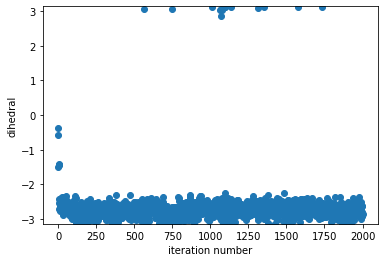

2.2475594254344453


In [45]:
# Plot old dihedrals
for angles in dihedrals[1]:
    plot_time_series(angles, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns__timeseries.png"))
    print(timeseries.statisticalInefficiency(angles))


## T42A complex -- eq

In [68]:
def make_neq_traj(outdir, htf, i, cycle, phase, is_old=True, keep_solvent=True):
    name = 'old' if is_old else 'new'
    topology = htf._topology_proposal.old_topology if is_old else htf._topology_proposal.new_topology
    positions = htf.old_positions(htf.hybrid_positions) if is_old else htf.new_positions(htf.hybrid_positions)
    modeller = app.Modeller(topology, positions)
    modeller.deleteWater()
    n_atoms = modeller.topology.getNumAtoms()
    
    snapshots = np.zeros((2000, n_atoms, 3))
    with open(os.path.join(outdir, f"{i}_{phase}_{cycle}_forward_eq_{name}.npy"), "rb") as f:
        snapshots = np.load(f)
            
    traj = md.Trajectory(snapshots, md.Topology.from_openmm(modeller.topology))
    
    return traj
       

In [56]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/23/10/"
i = 10
phase = 'complex'
is_old = True
cycle = 0
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [69]:
traj = make_neq_traj(outdir, htf, i, cycle, phase, is_old=is_old)

In [77]:
def get_dihedrals(traj, dihedral_indices_new_all, dihedral_indices_old_all):
    n_iter = traj.xyz.shape[0]
    
    dihedrals_all = []
    for dihedral_indices_list in [dihedral_indices_new_all, dihedral_indices_old_all]:
        dihedrals_sublist = []
        for dihedral_indices in dihedral_indices_list:
            dihedral_angles = md.compute_dihedrals(traj, np.array([dihedral_indices]))
            dihedrals_sublist.append(dihedral_angles)
        dihedrals_all.append(dihedrals_sublist)

    return dihedrals_all, n_iter

In [78]:
dihedrals, n_iter = get_dihedrals(traj, indices_new_all, indices_old_all)



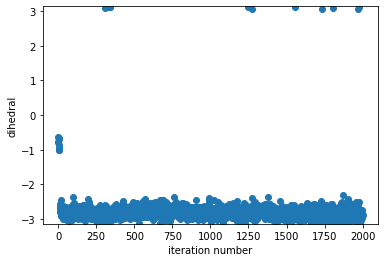

2.044916825198289


In [79]:
# Plot old dihedrals
for angles in dihedrals[1]:
    plot_time_series(angles, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns__timeseries.png"))
    print(timeseries.statisticalInefficiency(angles))


## T42A apo -- eq

In [80]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/23/10/"
i = 10
phase = 'apo'
is_old = True
cycle = 0
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [81]:
traj = make_neq_traj(outdir, htf, i, cycle, phase, is_old=is_old)

In [82]:
# Get old and new res objects
for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res

# Get atom names in old and new residues
names_old = [atom.name for atom in residue_old.atoms()]
names_new = [atom.name for atom in residue_new.atoms()]

# Get mapping from atom name to index in old and new residues
d_old = {atom.name : atom.index for atom in residue_old.atoms()}
d_new = {atom.name : atom.index for atom in residue_new.atoms()}

# Get lists of dihedral angles 
indices_old_all, indices_new_all = list(), list()
for angle_type in [md.geometry.dihedral.CHI1_ATOMS, 
                   md.geometry.dihedral.CHI2_ATOMS,
                   md.geometry.dihedral.CHI3_ATOMS,
                   md.geometry.dihedral.CHI4_ATOMS,
                   md.geometry.dihedral.CHI5_ATOMS]:
    for dihedral_list in angle_type:
        if all(atom_name in names_old for atom_name in dihedral_list):
            indices_old_all.append([d_old[atom_name] for atom_name in dihedral_list])
        if all(atom_name in names_new for atom_name in dihedral_list):
            indices_new_all.append([d_new[atom_name] for atom_name in dihedral_list])


dihedrals, n_iter = get_dihedrals(traj, indices_new_all, indices_old_all)



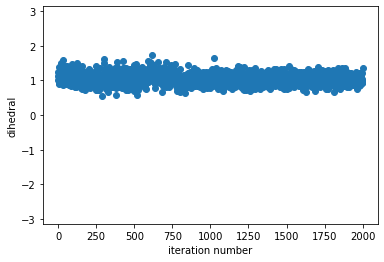

8.548507018875995


In [83]:
# Plot old dihedrals
for angles in dihedrals[1]:
    plot_time_series(angles, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns__timeseries.png"))
    print(timeseries.statisticalInefficiency(angles))


## T42A apo -- rest cache

In [5]:
outdir = "/data/chodera/zhangi/perses_benchmark/neq/22/24/"
i = 24
phase = 'apo'
htf = pickle.load(open(os.path.join(outdir, f"{i}_{phase}.pickle"), "rb"))

In [6]:
resid = '42'
name = 'THR'
length = 2

In [7]:
# Get old and new res objects
for res in htf._topology_proposal.old_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_old = res
for res in htf._topology_proposal.new_topology.residues():
    if res.id == resid and res.chain.index == 0:
        residue_new = res

# Get atom names in old and new residues
names_old = [atom.name for atom in residue_old.atoms()]
names_new = [atom.name for atom in residue_new.atoms()]

# Get mapping from atom name to index in old and new residues
d_old = {atom.name : atom.index for atom in residue_old.atoms()}
d_new = {atom.name : atom.index for atom in residue_new.atoms()}

# Get lists of dihedral angles 
indices_old_all, indices_new_all = list(), list()
for angle_type in [md.geometry.dihedral.CHI1_ATOMS, 
                   md.geometry.dihedral.CHI2_ATOMS,
                   md.geometry.dihedral.CHI3_ATOMS,
                   md.geometry.dihedral.CHI4_ATOMS,
                   md.geometry.dihedral.CHI5_ATOMS]:
    for dihedral_list in angle_type:
        if all(atom_name in names_old for atom_name in dihedral_list):
            indices_old_all.append([d_old[atom_name] for atom_name in dihedral_list])
        if all(atom_name in names_new for atom_name in dihedral_list):
            indices_new_all.append([d_new[atom_name] for atom_name in dihedral_list])

dihedrals, n_iter, all_pos_hybrid, box_vectors = get_dihedrals(i, name, length, outdir, htf, indices_new_all, indices_old_all)



100%|█| 2001/2001 [00:15<00:00, 130.29it


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager

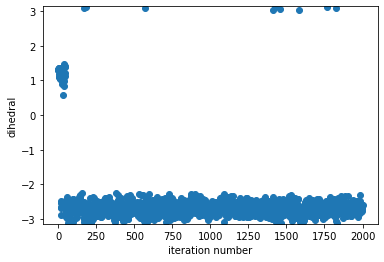

24.910125776384202


In [8]:
# Plot old dihedrals
for angles in dihedrals[1]:
    plot_time_series(angles, n_iter, os.path.join(outdir, f"{i}_{phase}_{name.lower()}_{length}ns__timeseries.png"))
    print(timeseries.statisticalInefficiency(angles))
